# REQUIREMENTS

In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

Dev Thoughts: will need to make sure this is using adj close for all returns, and that things like stock splits are accounted for to make it PiT. 

In [2]:
sp500_data = conn.raw_sql("""
SELECT
    caldt AS date,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '1990-01-01'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [3]:
risk_free_data = conn.raw_sql('''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '1990-01-01'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8748,2024-09-24,0.00020
8749,2024-09-25,0.00020
8750,2024-09-26,0.00020
8751,2024-09-27,0.00020


### COMPANY DATA

In [4]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')

In [30]:
company_search = 'NVIDIA' # FIND A COMPANY HERE

comps[comps['company_name'].str.contains(f'{company_search}')]

,permno,company_name
8,86580,NVIDIA CORP


In [31]:
company_name = 'NVIDIA CORP' # root variable for rest of notebook

comp0 = comps[comps['company_name'] == f'{company_name}']

company_permno = str(comp0['permno'][comp0.index[0]])

comp0

,permno,company_name
8,86580,NVIDIA CORP


In [32]:
#get gvkey
link = conn.raw_sql(f'''
SELECT *
FROM crsp.ccmxpf_linktable
WHERE lpermno = {company_permno};
''')

company_gvkey = link['gvkey'][0]

link

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,117768,P,01,LU,86580.0,16382.0,1.0,1999-01-22,None


Side Note: Not sure what month_end and month_start accomplish, but those are incorrect currently. It needs to be sampled from open trading days, not just calendar dates. Trying to implement that in the following sql query, but then this messes with the current forward fill code. Will need to merge dates with EOM from in between months to use this query instead & then still successfully forward fill. I [dev] will do later.

In [7]:
# company_fin_data = conn.raw_sql(f'''
# WITH monthly_data AS (
#     SELECT DISTINCT
#         date,
#         MIN(date) OVER (PARTITION BY DATE_TRUNC('month', date)) AS month_start,
#         MAX(date) OVER (PARTITION BY DATE_TRUNC('month', date)) AS month_end
#     FROM crsp.dsf
# ),
# financial_data AS (
#     SELECT
#         datadate AS date,
#         rdq AS reporting_date,
#         atq AS total_assets,
#         chq AS cash_holdings,
#         dlttq + dlcq AS total_debt,
#         ibq AS earnings,
#         xrdq AS rd_expense,
#         dvpq AS dividends_paid,
#         xintq AS interest_expense
#     FROM
#         comp.fundq
#     WHERE
#         gvkey = '{company_gvkey}'
#         AND datadate >= '1990-01-01'
# )
# SELECT
#     f.*,
#     m.month_start,
#     m.month_end
# FROM
#     financial_data f
# LEFT JOIN
#     monthly_data m
# ON
#     f.date = m.date
# ''')
# company_fin_data

In [8]:
company_fin_data = conn.raw_sql(f'''
SELECT
    datadate AS date,
    rdq AS reporting_date, -- Date of which information was reported
    atq AS total_assets,  -- Total Assets
    chq AS cash_holdings,  -- Cash and Short-Term Investments
    dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
    ibq AS earnings,  -- Earnings before extraordinary items
    xrdq AS rd_expense,  -- R&D expense
    dvpq AS dividends_paid,  -- Dividends paid
    xintq AS interest_expense  -- Interest expense
FROM
    comp.fundq
WHERE
    gvkey = '{company_gvkey}'
    AND datadate >= '1990-01-01'  -- Ensure data is after the link start date
''')

company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])

start_date = company_fin_data['date'].min()
end_date = company_fin_data['date'].max()
all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
full_range_df = pd.DataFrame({'date': all_months})

company_fin_data = pd.merge(full_range_df, company_fin_data, on='date', how='left')

company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
company_fin_data['month_end'] = company_fin_data['date']

company_fin_data

# company['date'] = company['reporting_date'] # backtest logic TODO



,date,reporting_date,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,month_start,month_end
0,1996-03-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-03-01,1996-03-31
1,1996-04-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-04-01,1996-04-30
2,1996-05-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-05-01,1996-05-31
3,1996-06-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-06-01,1996-06-30
4,1996-07-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-07-01,1996-07-31
...,...,...,...,...,...,...,...,...,...,...,...
339,2024-06-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-01,2024-06-30
340,2024-07-31,2024-08-28,85227.0,8563.0,10015.0,16599.0,3090.0,0.0,61.0,2024-07-01,2024-07-31
341,2024-08-31,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-08-01,2024-08-31
342,2024-09-30,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-01,2024-09-30


#### FORWARD FILL

In [9]:
company_fin_data = company_fin_data.ffill().dropna()
company_fin_data

,date,reporting_date,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,month_start,month_end
133,2007-04-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,2007-04-01,2007-04-30
134,2007-05-31,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,2007-05-01,2007-05-31
135,2007-06-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,2007-06-01,2007-06-30
136,2007-07-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,2007-07-01,2007-07-31
137,2007-08-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,2007-08-01,2007-08-31
...,...,...,...,...,...,...,...,...,...,...,...
339,2024-06-30,2024-05-22,77072.000,7587.000,11237.0,14881.000,2720.000,0.0,64.0,2024-06-01,2024-06-30
340,2024-07-31,2024-08-28,85227.000,8563.000,10015.0,16599.000,3090.000,0.0,61.0,2024-07-01,2024-07-31
341,2024-08-31,2024-08-28,85227.000,8563.000,10015.0,16599.000,3090.000,0.0,61.0,2024-08-01,2024-08-31
342,2024-09-30,2024-08-28,85227.000,8563.000,10015.0,16599.000,3090.000,0.0,61.0,2024-09-01,2024-09-30


Dev Thought: crsp.msf ends in 2023; our compustat data goes to sept 2024. will need to address later. also need to make sure these prices & returns are using adj close (think it's safe to say yes tho).

In [10]:
company_stock_prcs = conn.raw_sql(f'''
SELECT
    date,
    prc AS stock_price,
    ret AS stock_return,  -- Stock returns from CRSP
    prc * shrout AS market_cap  -- Market cap
FROM
    crsp.msf
WHERE
    permno = {company_permno}
''')

company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

company_stock_prcs

,date,stock_price,stock_return,market_cap
0,1998-12-31,NaN,NaN,NaN
1,1999-01-29,19.00000,NaN,5.433240e+05
2,1999-02-26,21.93750,0.154605,6.273248e+05
3,1999-03-31,21.12500,-0.037037,6.040905e+05
4,1999-04-30,18.25000,-0.136095,5.348892e+05
...,...,...,...,...
296,2023-08-31,493.54999,0.056196,1.219068e+09
297,2023-09-29,434.98999,-0.118570,1.074425e+09
298,2023-10-31,407.79999,-0.062507,1.005635e+09
299,2023-11-30,467.70001,0.146886,1.155219e+09


In [11]:
# Create new columns with just year and month
company_fin_data['year_month'] = company_fin_data['date'].dt.strftime('%Y-%m')
company_stock_prcs['year_month'] = company_stock_prcs['date'].dt.strftime('%Y-%m')

company = pd.merge(company_fin_data, company_stock_prcs, on='year_month')

company.drop(columns=['year_month', 'date_y'], axis=1, inplace=True)
company.rename(columns={'date_x':'date'}, inplace=True)

# company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='inner')

company

,date,reporting_date,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,month_start,month_end,stock_price,stock_return,market_cap
0,2007-04-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,2007-04-01,2007-04-30,32.89000,0.142807,1.193621e+07
1,2007-05-31,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,2007-05-01,2007-05-31,34.63900,0.053177,1.257094e+07
2,2007-06-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,2007-06-01,2007-06-30,41.31000,0.192586,1.499194e+07
3,2007-07-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,2007-07-01,2007-07-31,45.76000,0.107722,1.674244e+07
4,2007-08-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,2007-08-01,2007-08-31,51.16000,0.118007,1.871816e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023-08-31,2023-08-23,49555.000,5783.000,10954.0,6189.000,2041.000,0.0,65.0,2023-08-01,2023-08-31,493.54999,0.056196,1.219068e+09
197,2023-09-30,2023-08-23,49555.000,5783.000,10954.0,6189.000,2041.000,0.0,65.0,2023-09-01,2023-09-30,434.98999,-0.118570,1.074425e+09
198,2023-10-31,2023-11-21,54148.000,5519.000,11027.0,9243.000,2294.000,0.0,63.0,2023-10-01,2023-10-31,407.79999,-0.062507,1.005635e+09
199,2023-11-30,2023-11-21,54148.000,5519.000,11027.0,9243.000,2294.000,0.0,63.0,2023-11-01,2023-11-30,467.70001,0.146886,1.155219e+09


In [12]:
def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
    mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
    return agg_func(daily_data.loc[mask, column])

company['snp_return'] = company.apply(
    lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'daily_return', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

company['rf_rate'] = company.apply(
    lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                    lambda x: np.prod(1 + x) - 1), axis=1
)

company.drop(columns=['month_start', 'month_end'], axis=1, inplace=True)

# CALCULATIONS (CASH-HEDGING & RETURNS)

In [13]:
company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()

### $ b_{t}^{i} $ - return on cash between periods

In [14]:
# the paper calculates it in a pretty complicated method, we'll start like this
# company['b_it'] = ( company['cash_holdings'] - company['cash_holdings_t_minus_1'] ) / company['cash_holdings_t_minus_1']

In [15]:
data = company.copy()
data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])

# Y VALUES
data['r_minus_R'] = data['stock_return'] - data['rf_rate']

# REGRESSION VARIABLES
data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
data['gamma_8'] = data['leverage']
data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']

data = data.dropna()

In [16]:
y = data['r_minus_R']
X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              r_minus_R   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.267
Date:                Fri, 22 Nov 2024   Prob (F-statistic):              0.252
Time:                        15:06:40   Log-Likelihood:                 118.07
No. Observations:                 199   AIC:                            -214.1
Df Residuals:                     188   BIC:                            -177.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0240      0.020      1.208      0.2

In [17]:
data['marginal_cash_value'] = (
    model.params.iloc[0] +
    (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
    (model.params.iloc[11] * data['leverage'])
)

data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']

company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return


### $ e_{t}^{i} $ - cash hedged returns

In [18]:
# calculate the cash-hedged return (e_it)

company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

company

,date,reporting_date,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,stock_price,stock_return,market_cap,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return
0,2007-04-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,32.89000,0.142807,1.193621e+07,0.043292,0.004409,0.242407,NaN,NaN,NaN
1,2007-05-31,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,34.63900,0.053177,1.257094e+07,0.032547,0.003967,0.242407,678.951,NaN,NaN
2,2007-06-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,41.31000,0.192586,1.499194e+07,-0.017817,0.003998,0.242407,678.951,NaN,NaN
3,2007-07-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,45.76000,0.107722,1.674244e+07,-0.031985,0.003998,0.301273,678.951,0.155550,0.087100
4,2007-08-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,51.16000,0.118007,1.871816e+07,0.012864,0.004148,0.301273,914.745,0.177855,0.092202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023-08-31,2023-08-23,49555.000,5783.000,10954.0,6189.000,2041.000,0.0,65.0,493.54999,0.056196,1.219068e+09,-0.017717,0.004610,0.116699,5783.000,-0.053215,0.070651
197,2023-09-30,2023-08-23,49555.000,5783.000,10954.0,6189.000,2041.000,0.0,65.0,434.98999,-0.118570,1.074425e+09,-0.048720,0.004208,0.116699,5783.000,0.134645,-0.152024
198,2023-10-31,2023-11-21,54148.000,5519.000,11027.0,9243.000,2294.000,0.0,63.0,407.79999,-0.062507,1.005635e+09,-0.021980,0.004630,0.101924,5783.000,0.026428,-0.072600
199,2023-11-30,2023-11-21,54148.000,5519.000,11027.0,9243.000,2294.000,0.0,63.0,467.70001,0.146886,1.155219e+09,0.089178,0.004419,0.101924,5519.000,-0.129501,0.178254


In [19]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

company['cash_hedged_return'] = winsorize(company['cash_hedged_return'])

company

,date,reporting_date,total_assets,cash_holdings,total_debt,earnings,rd_expense,dividends_paid,interest_expense,stock_price,stock_return,market_cap,snp_return,rf_rate,cash_share_weight,cash_holdings_t_minus_1,b_it,cash_hedged_return
0,2007-04-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,32.89000,0.142807,1.193621e+07,0.043292,0.004409,0.242407,NaN,NaN,NaN
1,2007-05-31,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,34.63900,0.053177,1.257094e+07,0.032547,0.003967,0.242407,678.951,NaN,NaN
2,2007-06-30,2007-05-10,2800.868,678.951,0.0,132.259,158.321,0.0,0.0,41.31000,0.192586,1.499194e+07,-0.017817,0.003998,0.242407,678.951,NaN,NaN
3,2007-07-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,45.76000,0.107722,1.674244e+07,-0.031985,0.003998,0.301273,678.951,0.155550,0.087100
4,2007-08-31,2007-08-09,3036.267,914.745,0.0,172.732,157.952,0.0,0.0,51.16000,0.118007,1.871816e+07,0.012864,0.004148,0.301273,914.745,0.177855,0.092202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023-08-31,2023-08-23,49555.000,5783.000,10954.0,6189.000,2041.000,0.0,65.0,493.54999,0.056196,1.219068e+09,-0.017717,0.004610,0.116699,5783.000,-0.053215,0.070651
197,2023-09-30,2023-08-23,49555.000,5783.000,10954.0,6189.000,2041.000,0.0,65.0,434.98999,-0.118570,1.074425e+09,-0.048720,0.004208,0.116699,5783.000,0.134645,-0.152024
198,2023-10-31,2023-11-21,54148.000,5519.000,11027.0,9243.000,2294.000,0.0,63.0,407.79999,-0.062507,1.005635e+09,-0.021980,0.004630,0.101924,5783.000,0.026428,-0.072600
199,2023-11-30,2023-11-21,54148.000,5519.000,11027.0,9243.000,2294.000,0.0,63.0,467.70001,0.146886,1.155219e+09,0.089178,0.004419,0.101924,5519.000,-0.129501,0.178254


# BETA CALCULATION

In [20]:
window = 65 # months

def calculate_rolling_beta(stock_return, market_return, window):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

In [21]:

company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'], window)
company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'], window)
company['snp_beta'] = calculate_rolling_beta(company['snp_return'], company['snp_return'], window)

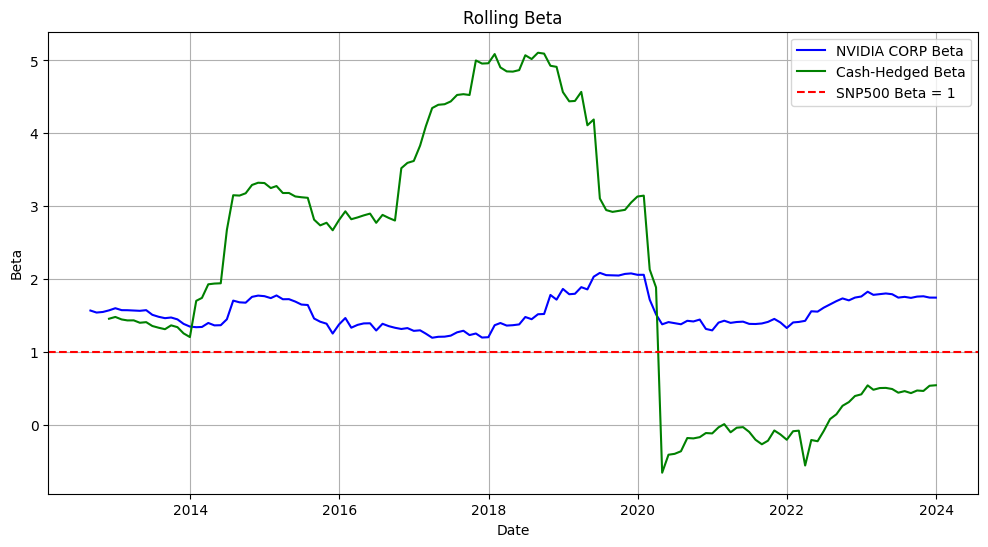

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['company_beta'], label=f'{company_name} Beta', color='blue')
plt.plot(company['date'], company['cash_hedged_beta'], label='Cash-Hedged Beta', color='green')
plt.axhline(1, color='red', linestyle='--', label='SNP500 Beta = 1')
plt.title('Rolling Beta')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
#plt.ylim(-0, 2)
plt.grid()
plt.show()


## RETURNS ANALYSIS

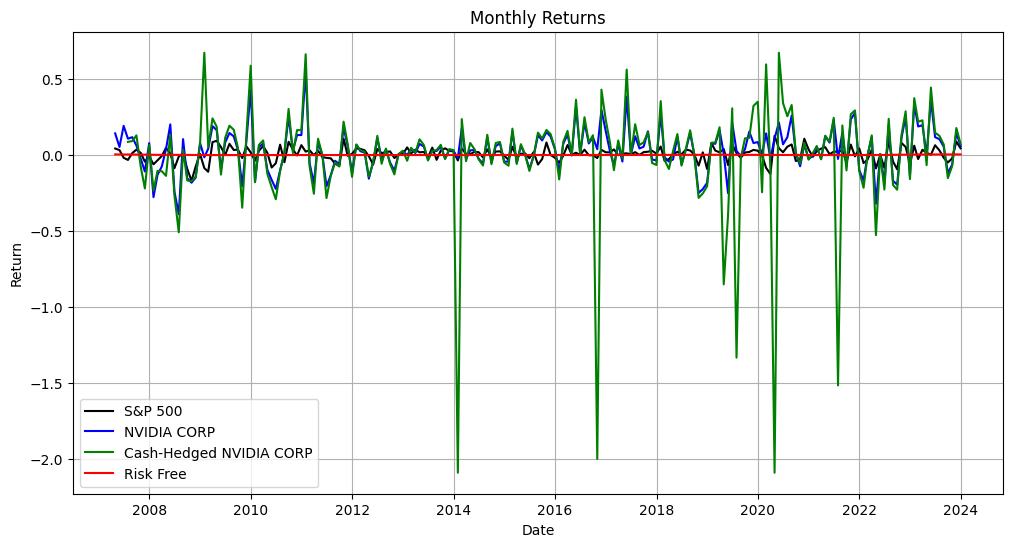

In [23]:

plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['snp_return'], label='S&P 500', color='black')
plt.plot(company['date'], company['stock_return'], label=f'{company_name}', color='blue')
plt.plot(company['date'], company['cash_hedged_return'], label=f'Cash-Hedged {company_name}', color='green')
plt.plot(company['date'], company['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [24]:
company['snp_cum_return'] = (1 + company['snp_return']).cumprod() - 1
company['company_cum_return'] = (1 + company['stock_return']).cumprod() - 1
company['cash_hedged_cum_return'] = (1 + company['cash_hedged_return']).cumprod() - 1
company['rf_cum_return'] = (1 + company['rf_rate']).cumprod() - 1

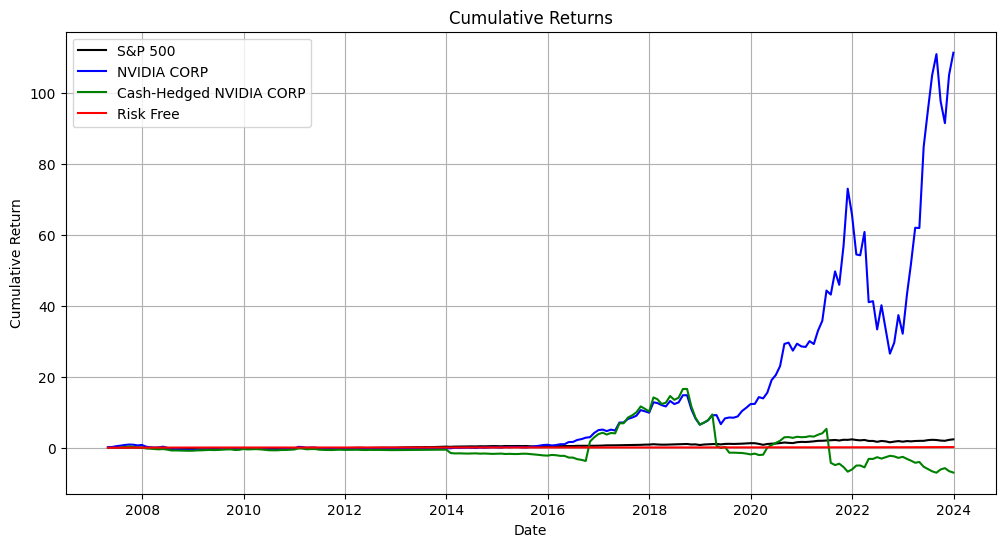

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(company['date'], company['snp_cum_return'], label='S&P 500', color='black')
plt.plot(company['date'], company['company_cum_return'], label=f'{company_name}', color='blue')
plt.plot(company['date'], company['cash_hedged_cum_return'], label=f'Cash-Hedged {company_name}', color='green')
plt.plot(company['date'], company['rf_cum_return'], label='Risk Free', color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

In [26]:
def sharpe(ret):
    excess_ret = company[f"{ret}"] - company["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print("ANNUALISED:")

pd.DataFrame(
    [
        ["SNP500" , '{0:.4f}'.format(sharpe('snp_return')), (1 + company['snp_return'].mean()) ** 12 - 1, (1 + (company['snp_return'].std()**2)) ** 12 - 1],
        [f"{company_name}" , '{0:.4f}'.format(sharpe('stock_return')), (1 + company['stock_return'].mean()) ** 12 - 1, (1 + (company['stock_return'].std()**2)) ** 12 - 1],
        [f"Cash Hedged {company_name}" , '{0:.4f}'.format(sharpe('cash_hedged_return')), (1 + company['cash_hedged_return'].mean()) ** 12 - 1, (1 + (company['cash_hedged_return'].std()**2)) ** 12 - 1]
    ],
    columns=['Asset', 'SHARPE', 'Mean Return', 'Volatility']
)

ANNUALISED:


,Asset,SHARPE,Mean Return,Volatility
0,SNP500,0.4705,0.088856,0.025905
1,NVIDIA CORP,0.8104,0.478346,0.254192
2,Cash Hedged NVIDIA CORP,-0.0566,-0.059088,3.258124


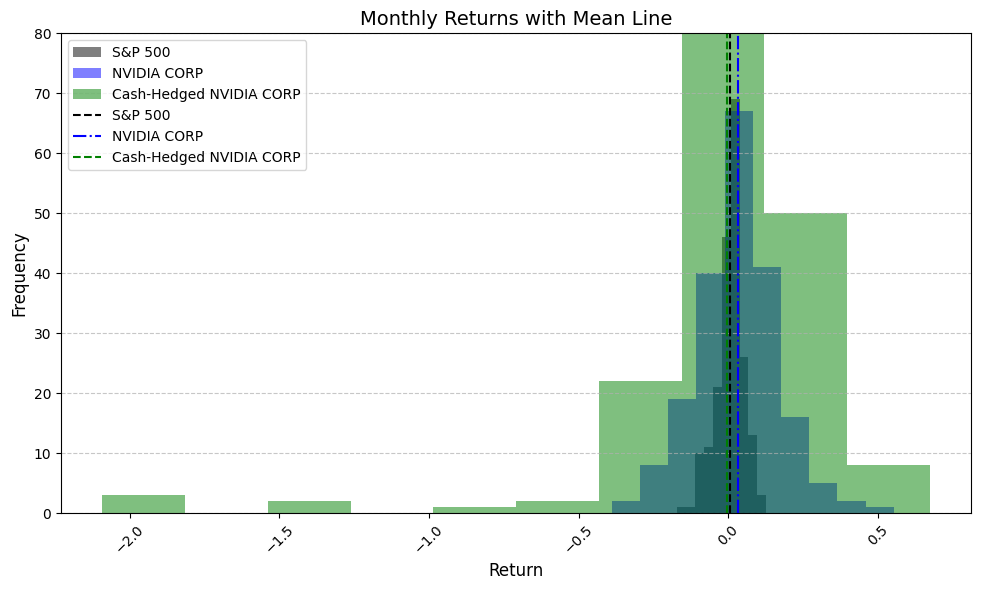

In [27]:
plt.figure(figsize=(10, 6))

plt.hist(company['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(company['stock_return'], label=f'{company_name}', color='blue', alpha=0.5)
plt.hist(company['cash_hedged_return'], label=f'Cash-Hedged {company_name}', color='green', alpha=0.5)

plt.axvline(company["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(company["stock_return"].mean(), color="blue", linestyle="-.", label=f'{company_name}')
plt.axvline(company["cash_hedged_return"].mean(), color="green", linestyle="--", label=f'Cash-Hedged {company_name}')

plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.ylim(0, 80)
plt.show()